# Tuto\#4 Using the MCMC tool of GRIP
The fit with the likelihood or the least squares underestimate the uncertainties on the fitted parameters.

The MCMC tackles this and GRIP is the `emcee` package to run a MCMC. 
It can be used to do a full fit (although the MCMC may be lost by the permanent changes in the parameters space due to the simulation of the data).
It can also be used to estimate the posterior of the parameters by initiating it from the optimised values, allowing to estimate their uncertainties.

## Load data and get the histogram

In [1]:
import h5py
import numpy as np
import os
from timeit import default_timer as time
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import corner
import grip
try:
    import cupy as cp # To use the GPU to speed up the process
    onGpu = True
except ModuleNotFoundError:
    import numpy as cp # If no GPU, we load numpy again with the same acronym to still use the functions
    onGpu = False

datafolder = 'dataset/'
darkfolder = datafolder
save_path = 'results/'

In [2]:
wl_min, wl_max = 11000, 11200
dark_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5']
data_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5']
dark = grip.load_data(dark_list, ['wl_scale', 'Iminus1', 'p1', 'p2'], (wl_min, wl_max), 'hdf5')
data = grip.load_data(data_list, ['wl_scale', 'Iminus1', 'p1', 'p2', 'piston_rms'], (wl_min, wl_max), 'hdf5')

wl_scale = data['wl_scale']
dark_IA, dark_IB = dark['p1'], dark['p2']
dark_Iminus = dark['Iminus1']
Iminus = data['Iminus1']
data_IA, data_IB = data['p1'], data['p2']

# Calculate the null depth
Iplus = data_IA + data_IB + 2 * (data_IA * data_IB)**0.5 # Using the estimator above
data_null = Iminus / Iplus # Calculated null depth

# Get the histogram
bin_bounds = (-0.01, 0.1) # Minimum and maximum values of the bins of the histogram
normed = False # We want to normalise the histogram by its sum

null_axis, null_pdf, null_pdf_err, sz = grip.compute_data_histogram(data_null, \
                                                          bin_bounds, \
                                           wl_scale, normed=normed)

injection, spectra = grip.get_injection_and_spectrum(
    data_IA, data_IB, wl_scale, (wl_min, wl_max))
nb_frames_binning_photometry = -1 # Bin over all the sample
injection, dummy = grip.binning(
    injection, nb_frames_binning_photometry, axis=1, avg=True)


data_IA_axis = cp.linspace(injection[0].min(), injection[0].max(),
                           np.size(np.unique(injection[0])),
                           dtype=cp.float32)
cdf_data_IA = grip.computeCdf(data_IA_axis, injection[0], 'cdf', True)
cdf_data_IA = cp.array(cdf_data_IA, dtype=cp.float32)

data_IB_axis = cp.linspace(injection[1].min(), injection[1].max(),
                           np.size(np.unique(injection[1])),
                           dtype=cp.float32)
cdf_data_IB = grip.computeCdf(data_IB_axis, injection[1], 'cdf', True)
cdf_data_IB = cp.array(cdf_data_IB, dtype=cp.float32)

sigma_eps = data['piston_rms']
sigma_eps = np.radians(sigma_eps)
sigma_eps *= 2200 / wl_scale
sigma_eps = sigma_eps.reshape((1, -1))
sigma_eps_axis, sigma_eps_cdf = grip.get_dark_cdf(sigma_eps, wl_scale)

std_dark_Iminus = np.std(dark_Iminus)
dark_Iminus -= np.mean(dark_Iminus, 1, keepdims=True) # The model is better when the data are forced to be of average 0
    
dark_Iminus_axis, dark_Iminus_cdf = grip.get_dark_cdf(
    dark_Iminus, wl_scale)

rvu_opd = {'normal1':None} # To generate RV reproducing the statistics of the OPD fluctuations
rvu_IA = None # To generate RV reproducing the statistics of the injection of beam A
rvu_IB = None # To generate RV reproducing the statistics of the injection of beam B
rvu_bg = [None]*wl_scale.size # To generate RV reproducing the statistics of the thermal background, per spectral channel
rvu_eps = [None]*wl_scale.size # To generate RV reproducing the statistics of the fringe blurring, per spectral channel

# Uncomment the lines below to play with "deterministic" Monte-Carlo
# rvu_opd = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_IA = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_IB = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_bg = cp.random.uniform(0, 1, size=(wl_scale.size, n_samp_per_loop), dtype=cp.float32)
# rvu_eps = cp.random.uniform(0, 1, size=(wl_scale.size, n_samp_per_loop), dtype=cp.float32)

# Embed all of the above in lists
rvus = [rvu_IA, rvu_IB, rvu_bg, rvu_eps]
cdfs = [(data_IA_axis, cdf_data_IA), (data_IB_axis, cdf_data_IB),\
        (dark_Iminus_axis, dark_Iminus_cdf), (sigma_eps_axis, sigma_eps_cdf)]

n_samp_total = int(2e6)
n_samp_per_loop = int(1e6)
nloop = n_samp_total // n_samp_per_loop


dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5
dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5


Then we set the initial guesses

In [3]:
bounds_mu = (0, 800) # Boundaries of mu opd
bounds_sig = (200, 400) # Boundaries of sig opd
bounds_na = (0.0, 0.01) # Boundaries of Na
# Compile them into a readable tuple called by the TRF algorithm
param_bounds = [bounds_na, bounds_mu, bounds_sig]

mu_opd = 20 # initial guess of DeltaPhi mu
sig_opd = 340 # initial guess of DeltaPhi sig
na = 0.0063 # initial guess of astro null
key = 'LBTI Null'

initial_guess = [na, mu_opd, sig_opd]
initial_guess = np.array(initial_guess, dtype=np.float64)
label_guess = ['deterministic', 'normal1', 'normal1']

spec_chan_width = 2600

instrument_constants = (spec_chan_width, np.pi)

As a safety, we can plot the histograms and its model to see if evreythin is correct.

(2, 0.0063, 20.0, 340.0)
76.73959203865525


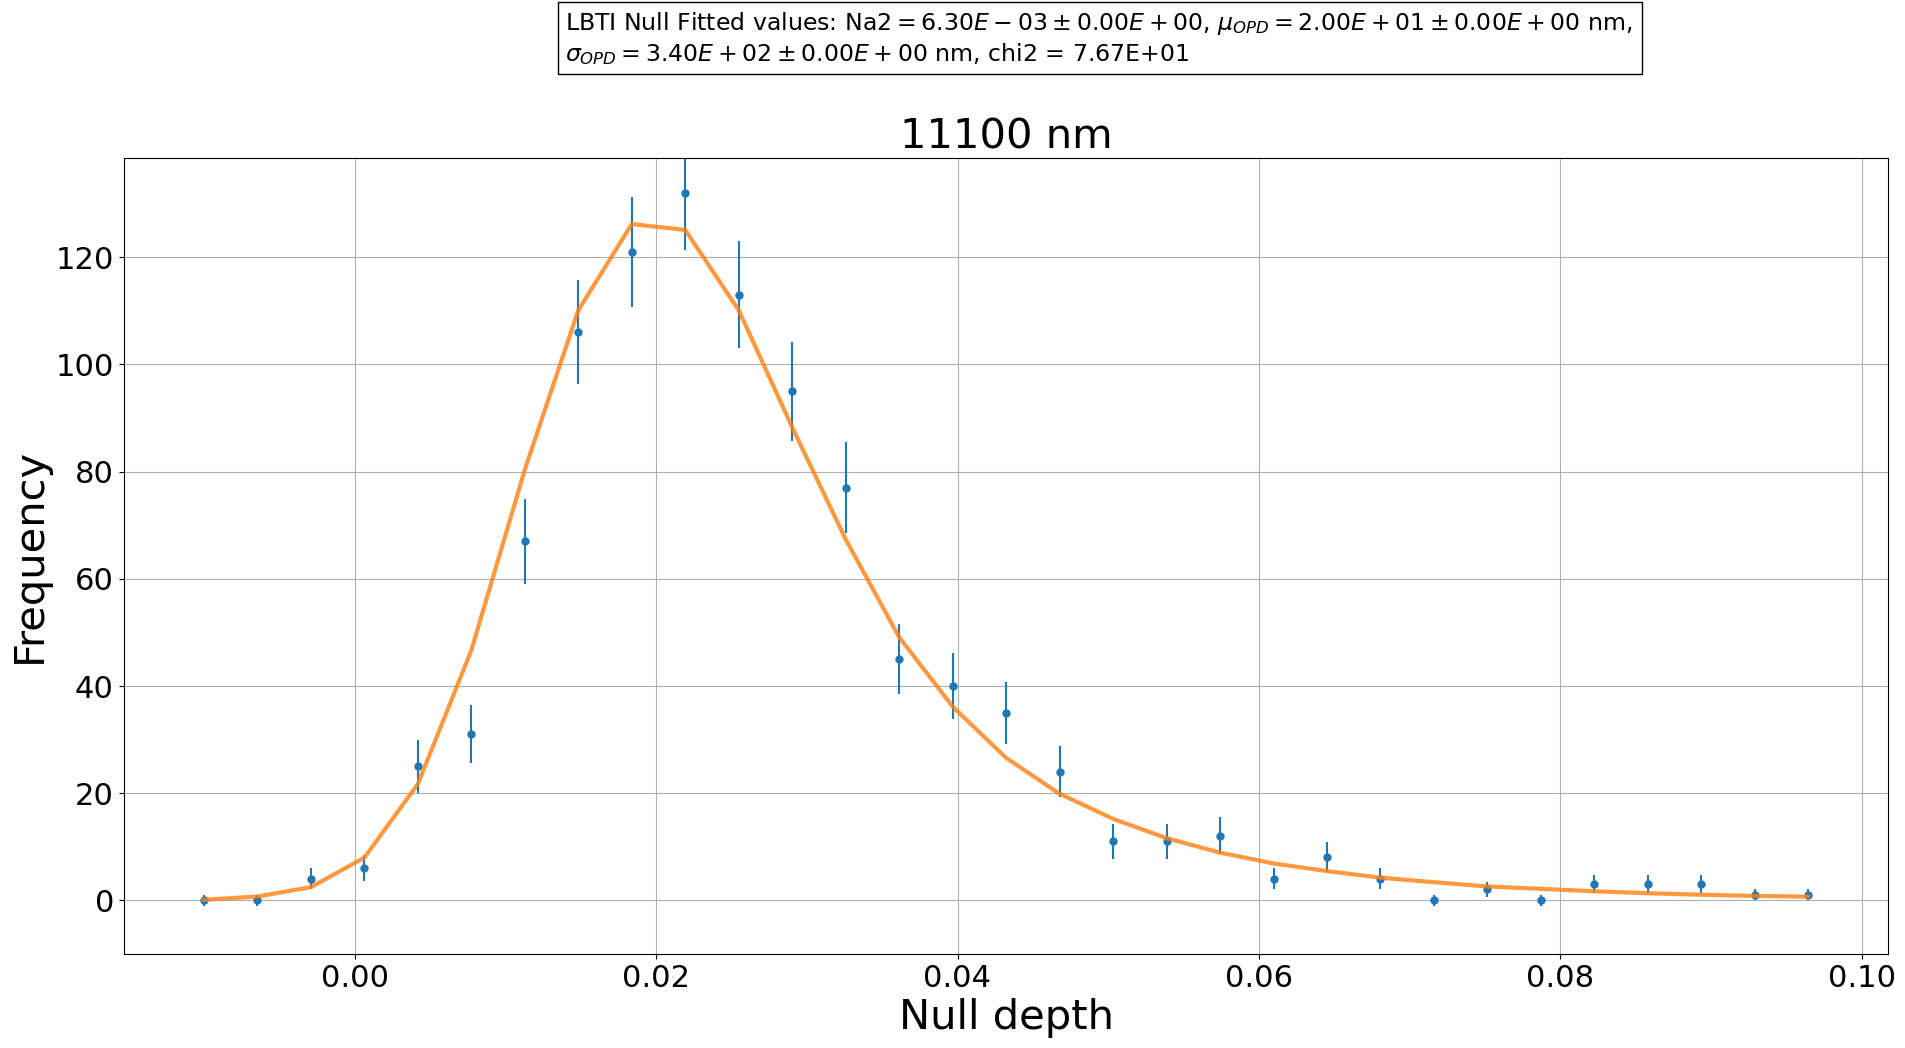

In [5]:
out = grip.create_histogram_model(initial_guess, null_axis, label_guess, wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus, \
                                  n_samp_per_loop=n_samp_per_loop, nloop=nloop)
synth_histo = out[0] # Flatten histogram along the wavelength axis.
synth_histo = synth_histo / synth_histo.sum() * null_pdf.sum()

diag = out[1][0]
diag = cp.array(diag)
if onGpu:
    diag = cp.asnumpy(diag)
    diag_IA = cp.asnumpy(cp.array(out[2][0][0][1]))
    diag_IB = cp.asnumpy(cp.array(out[2][0][0][1]))
    diag_dkIA = cp.asnumpy(cp.array(out[3])[0,:,0])
    diag_dkIB = cp.asnumpy(cp.array(out[3])[0,:,1])
else:
    diag = cp.array(diag)
    diag_IA = out[2][0][0][0]
    diag_IB = out[2][0][0][1]
    diag_dkIA = np.array(out[3])[0,:,0]
    diag_dkIB = np.array(out[3])[0,:,1] 

uncertainties = np.zeros(3)
popt = (np.array([na, mu_opd, sig_opd]), np.ones((3, 3)))
neg_log_multinomial = grip.return_neg_func(grip.log_multinomial)
extra_args = [null_pdf_err]
lklh = neg_log_multinomial(popt[0], null_pdf, grip.create_histogram_model, *extra_args, use_this_model=synth_histo, normed=normed)
print(lklh)


nb_rows_plot = 3
label_optimizer = 'chi2'
key = 'LBTI Null'
text_params = '%s ' % key+'Fitted values: ' +\
    'Na2$ = %.2E \pm %.2E$, ' % (na,
                                uncertainties[0]) +\
    r'$\mu_{OPD} = %.2E \pm %.2E$ nm, ' % (popt[0][1],
                                            uncertainties[1]) +\
    '\n' + r'$\sigma_{OPD} = %.2E \pm %.2E$ nm,' % (
        popt[0][2], uncertainties[2]) +\
    ' '+label_optimizer+' = %.2E ' % (lklh)
    
save_name = key + '_' + str(wl_min) + '-' + str(wl_max) + '_' + os.path.basename(datafolder[:-1])
grip.plot_null_distributions(nb_rows_plot, wl_scale, text_params, null_axis, null_pdf,\
                            null_pdf_err, save_path, save_name, model=synth_histo,\
                                save_fig=False)


Now, we can use the MCMC.
The posterior is the product of a priori and a likelihood.
The MCMC as done by `emcee` aims at **maximise** the posterior while the likelihood used aims at **minimise** the cost function.

GRIP uses a uniform prior on the parameters with the boundaries set by the user.

The function to use is `grip.mcmc(params, lklh_func, bounds, func_model, data, func_args=(), func_kwargs={}, neg_lklh=True, nwalkers=6, nstep=2000, progress_bar=True)`:
- `params`: the parameters to explore
- `lklh_func`: the cost function
- `bounds`: the boundaries of the parameter space
- `func_model`: the model to fit (e.g. `create_histogram_model`)
- `data`: the data on which the model is fitted
- `func_args`: tuple of the arguments to pass to `func_model` (which also embeds the null depth estimator and its argument)
- `func_kwargs`: dictionary of keywords to pass to `func_model`
- `neg_lklh`: a boolean to tell `grip.mcmc` the likelihood function returns the negative likelihood
- `nwalkers`: number of walkers to generate during the MCMC
- `nstep`: the number of steps each walker do
- `progress_bar`: shows a progress bar

The argument `neg_lklh` allows to correct the sign of the likelihood so the algorithm is not lost at the edges of the parameter space.

In [6]:
func_args = [null_axis, label_guess, wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus]
func_kwargs = {'n_samp_per_loop':n_samp_per_loop, 'nloop':nloop, 'normed':False, 'verbose':False}
nwalkers = 6
nsteps = 5000

samples, flat_samples, sampler, all_samples = grip.mcmc(initial_guess, grip.log_multinomial, param_bounds, 
                                                          grip.create_histogram_model, null_pdf, 
                                                          func_args=func_args, func_kwargs=func_kwargs, neg_lklh=True, 
                                                          nwalkers=nwalkers, nstep=nsteps, progress_bar=True)

print('Acceptance fraction:', sampler.acceptance_fraction)

100%|██████████| 5000/5000 [05:05<00:00, 16.36it/s]

Acceptance fraction: [0.4922 0.484  0.4868 0.4886 0.491  0.4866]


Once the MCMC done, we can plot corner plots to see how the posteriors of the 3 parameters look like.

Median null +/- error: 0.00705488300602353 0.0004399541804834626 0.0004188126235368794
Median Mu +/- error: 108.11006824468855 71.39636284535261 74.29319098596444
Median Sig +/- error: 324.4194801904724 32.697550227259114 19.15769316489957


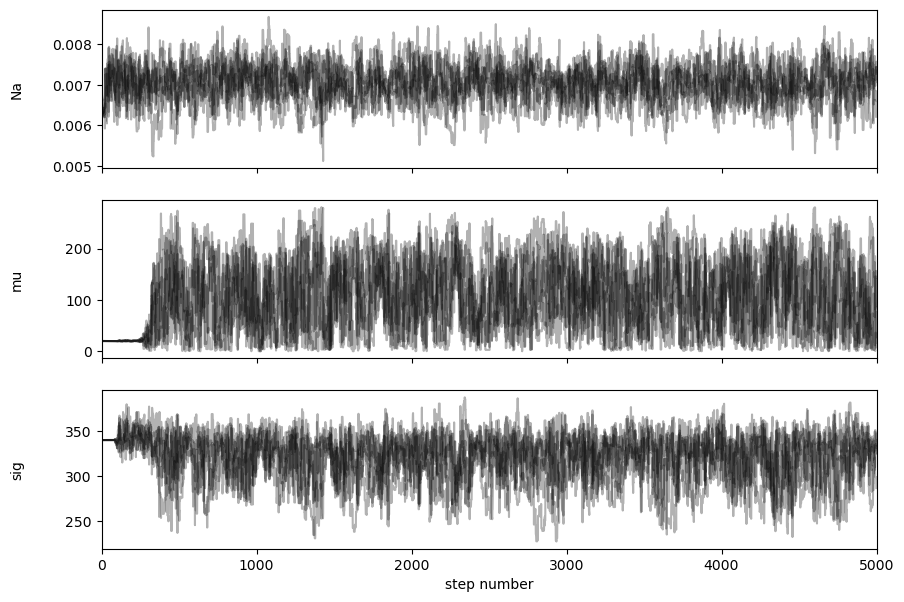

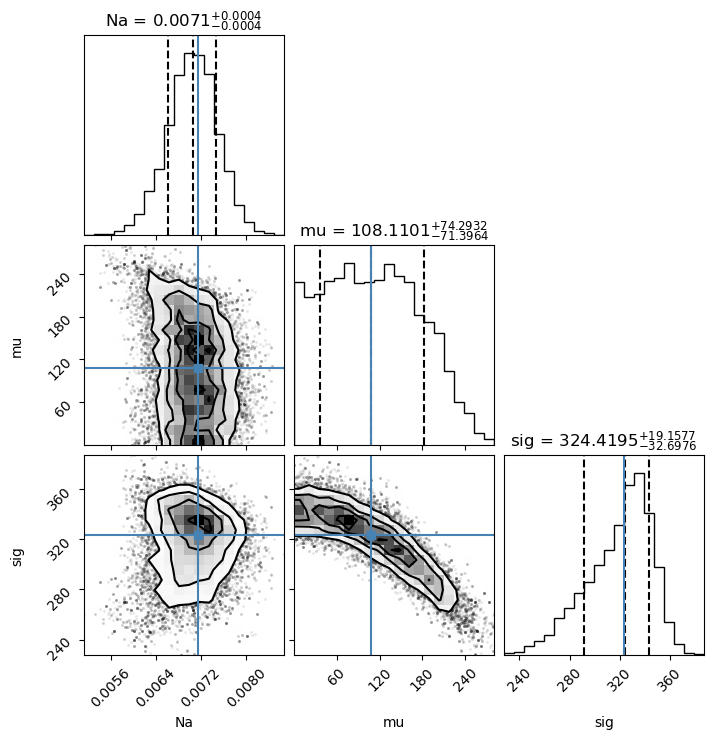

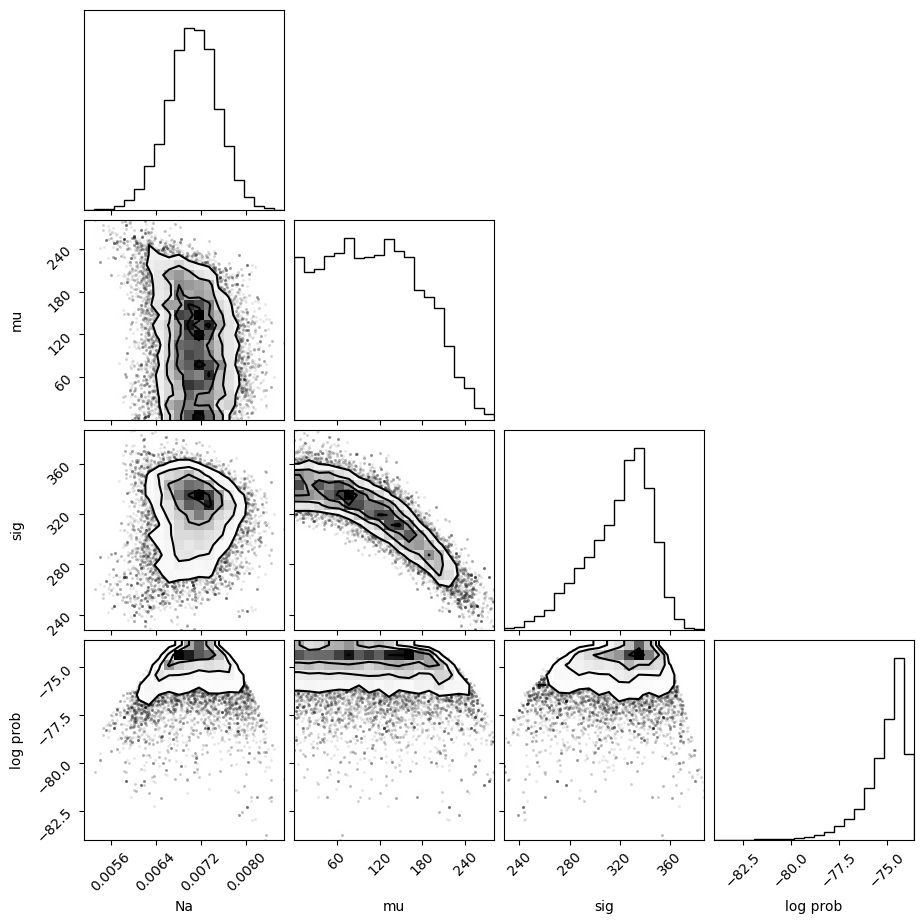

In [7]:
labels = ['Na', 'mu', 'sig']
initial_positions = [0.007143871175864696, 107.53, 323.5]

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

fig = corner.corner(flat_samples, labels=labels, 
                    truths=initial_positions, 
                    quantiles=(0.16, 0.5, 0.84), show_titles=True,
                    title_fmt='.4f')

quantiles_null = corner.quantile(flat_samples[:,0], (0.16, 0.5, 0.84))
quantiles_mu = corner.quantile(flat_samples[:,1], (0.16, 0.5, 0.84))
quantiles_sig = corner.quantile(flat_samples[:,2], (0.16, 0.5, 0.84))
print('Median null +/- error:', quantiles_null[1], quantiles_null[1]-quantiles_null[0], quantiles_null[2]-quantiles_null[1])
print('Median Mu +/- error:', quantiles_mu[1], quantiles_mu[1]-quantiles_mu[0], quantiles_mu[2]-quantiles_mu[1])
print('Median Sig +/- error:', quantiles_sig[1], quantiles_sig[1]-quantiles_sig[0], quantiles_sig[2]-quantiles_sig[1])

log_prob_samples = sampler.get_log_prob(discard=min(nsteps//10, 600), flat=True)
all_samples = np.concatenate((flat_samples, log_prob_samples[:, None]), axis=1)
labels += ["log prob", "log prior"]
corner.corner(all_samples[:,:4], labels=labels);

By widening the null depth, we have more appropriate posteriors for the parameters.
From there, error bars, confidence intervals or any other uncertainty metrics can be deduced.

## Congratulations, we know how to use MCMC with GRIP to get the uncertainty on the self-calibrated null depth.